In [1]:
import torch 
import torchaudio
import transformers  

print(torch.__version__)
print(torchaudio.__version__)
print(transformers.__version__)

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from IPython.display import Audio
from tqdm import tqdm

from pathlib import Path

root_to_data = Path('/kaggle/input/freesound-audio-tagging')
test_path = f'{root_to_data}/audio_test/' # path to dir with .wav audio test data 
train_path = f'{root_to_data}/audio_train/' # path to dir with .wav audio train data 

2.1.2
2.1.2
4.39.3


In [2]:
sample_sub = pd.read_csv(f'{root_to_data}/sample_submission.csv')
print(sample_sub.shape)
print(sample_sub.head(-1))
sample_sub_wav, sample_rate_sub = torchaudio.load(f'{test_path}/{sample_sub.fname[0]}')
Audio(sample_sub_wav.numpy(), rate=sample_rate_sub)
sample_sub = sample_sub.drop(['label'], axis=1)
print(sample_sub.head(3))

(9400, 2)
             fname                  label
0     00063640.wav  Laughter Hi-Hat Flute
1     0013a1db.wav  Laughter Hi-Hat Flute
2     002bb878.wav  Laughter Hi-Hat Flute
3     002d392d.wav  Laughter Hi-Hat Flute
4     00326aa9.wav  Laughter Hi-Hat Flute
...            ...                    ...
9394  ffd9d282.wav  Laughter Hi-Hat Flute
9395  ffe76321.wav  Laughter Hi-Hat Flute
9396  ffe8d42d.wav  Laughter Hi-Hat Flute
9397  ffeba2cd.wav  Laughter Hi-Hat Flute
9398  fff6d073.wav  Laughter Hi-Hat Flute

[9399 rows x 2 columns]
          fname
0  00063640.wav
1  0013a1db.wav
2  002bb878.wav


# **DATA**

In [3]:
wav_array = os.listdir(train_path) # array with name .wav files for path to it 
print(len(os.listdir(train_path)))
print(wav_array[:5])
print(type(wav_array))

9473
['66dd3d3b.wav', 'edf36df4.wav', '6496bf6a.wav', 'cc046f8d.wav', '34881c5f.wav']
<class 'list'>


In [4]:
index_wav = 0
for i in range (0, len(wav_array)):
    if wav_array[i] == '001ca53d.wav':
        index_wav = i
        print(i)
        break 
waveform_example, sample_rate_example = torchaudio.load(train_path + wav_array[index_wav])
Audio(waveform_example.numpy(), rate=sample_rate_example) # if we compare the sound with label in the train we can make a conclusion about it's Hi-hat

2088


(9473, 3)
          fname         label  manually_verified
0  00044347.wav        Hi-hat                  0
1  001ca53d.wav     Saxophone                  1
2  002d256b.wav       Trumpet                  0
3  0033e230.wav  Glockenspiel                  1
4  00353774.wav         Cello                  1


<Axes: xlabel='label'>

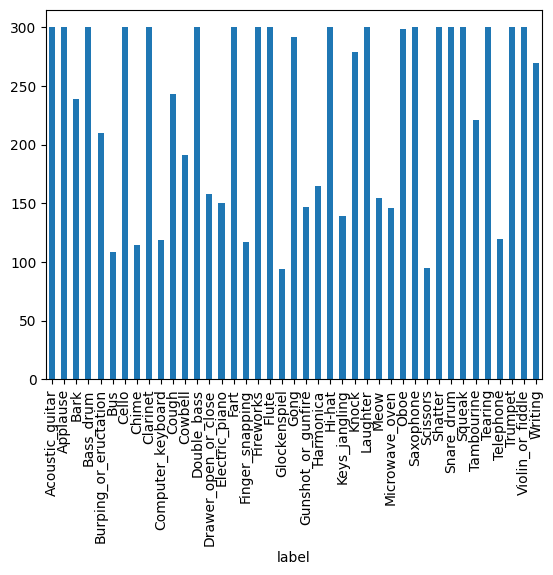

In [5]:
train = pd.read_csv(f'{root_to_data}/train.csv')
print(train.shape)
print(train.head())
train.groupby(['label']).size().plot.bar()

In [6]:
'''
count and print unique labels from train
'''
unique_labels = train.label.unique()
print(len(unique_labels))
print(unique_labels)

41
['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


In [7]:
'''
Let`s merge wav_array and train  
'''

wav_df = {}

# **EXPLORE AUDIO SAMPLING**

In [8]:
path_to_audio = train_path + wav_array[0]
waveform, sample_rate = torchaudio.load(path_to_audio)
print(waveform, sample_rate)

tensor([[ 4.8370e-02,  4.7089e-02,  4.6722e-02,  ..., -3.0518e-05,
          0.0000e+00, -3.0518e-05]]) 44100


In [9]:
def plot_waveform(waveform, sample_rate):
    '''
    func for plot
    '''
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

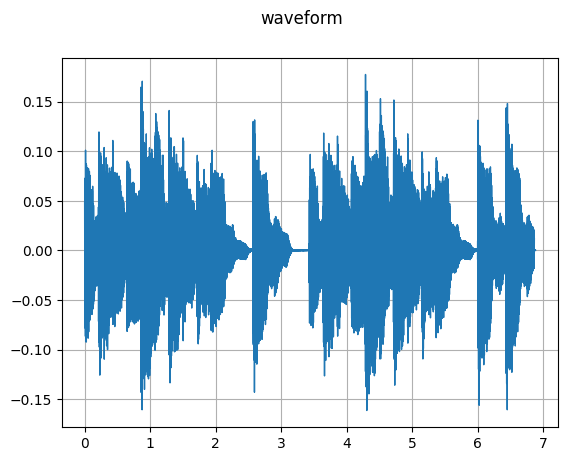

In [10]:
plot_waveform(waveform, sample_rate)

In [11]:
def plot_spectogram(waveform, sample_rate, title="Spectrogram"):
    '''
    func for spectrogram 
    '''
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

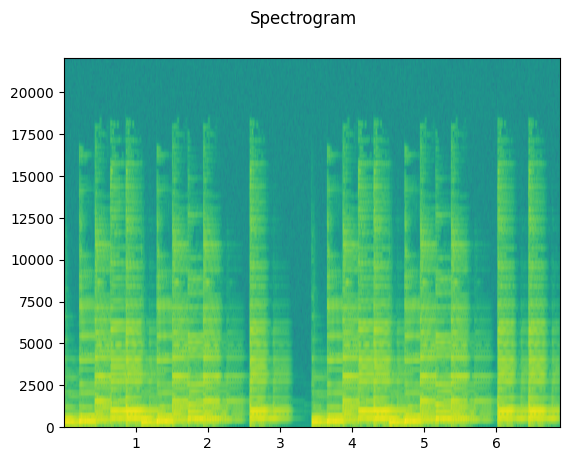

In [12]:
plot_spectogram(waveform, sample_rate)

In [13]:
'''
metadata about .wav file
'''
metadata = torchaudio.info(path_to_audio)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=303408, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [14]:
Audio(waveform.numpy()[0], rate=sample_rate)

In [15]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1, stratify=train.label)

print(train_df.shape)
print(valid_df.shape)

(7578, 3)
(1895, 3)


# **FIT (*USE TRANSFORMERS*)**

In [16]:
'''
I try to use pre-trained transformers model for audio classification
'''
from transformers import pipeline
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor, TrainingArguments, Trainer
from torch.utils.data import DataLoader

candidate_labels = unique_labels # labels, which pipeline model can predict

2024-04-22 18:49:38.405745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 18:49:38.405865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 18:49:38.565324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
'''
audio_classifier by transformers pipeline. It`s just example
We will use pretrained model from hugging face, not pipeline/ For finetunning
'''

audio_classifier = pipeline(task="zero-shot-audio-classification", model="laion/clap-htsat-unfused")

config.json:   0%|          | 0.00/5.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/615M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

In [18]:
audio_4_transformer, sample_rate_4_transformer = torchaudio.load(train_path + wav_array[2088])

result = audio_classifier(audio_4_transformer.numpy()[0], candidate_labels=candidate_labels)
result# that classifier work good

[{'score': 0.9490321278572083, 'label': 'Saxophone'},
 {'score': 0.016778023913502693, 'label': 'Violin_or_fiddle'},
 {'score': 0.016634363681077957, 'label': 'Clarinet'},
 {'score': 0.009456333704292774, 'label': 'Trumpet'},
 {'score': 0.0017909208545461297, 'label': 'Telephone'},
 {'score': 0.001406187191605568, 'label': 'Cello'},
 {'score': 0.0010782320750877261, 'label': 'Snare_drum'},
 {'score': 0.0005330663989298046, 'label': 'Gunshot_or_gunfire'},
 {'score': 0.0004148970474489033, 'label': 'Flute'},
 {'score': 0.00032973059569485486, 'label': 'Drawer_open_or_close'},
 {'score': 0.0002919694525189698, 'label': 'Computer_keyboard'},
 {'score': 0.00023962324485182762, 'label': 'Harmonica'},
 {'score': 0.00020924162527080625, 'label': 'Oboe'},
 {'score': 0.0001598966628080234, 'label': 'Writing'},
 {'score': 0.00015090942906681448, 'label': 'Glockenspiel'},
 {'score': 0.00013809953816235065, 'label': 'Fart'},
 {'score': 0.0001376107393298298, 'label': 'Double_bass'},
 {'score': 0.00

In [25]:
%%time
prediction_array = []
for wav_index in tqdm(range(0, sample_sub.shape[0])):
    wav_arr, sample_rate = torchaudio.load(f'{test_path}/{sample_sub.fname[0]}')
    
    prediction = audio_classifier(wav_arr.numpy()[0], candidate_labels=candidate_labels)
    prediction_array.append(prediction[0]['label'])
    
sample_sub['label'] = prediction_array
print(sample_sub.shape)
print(sample_sub.head(3)) #Such long solution and bad score

100%|██████████| 9400/9400 [2:16:30<00:00,  1.15it/s]  

(9400, 2)
          fname    label
0  00063640.wav  Shatter
1  0013a1db.wav  Shatter
2  002bb878.wav  Shatter
CPU times: user 4h 35min 12s, sys: 34min 20s, total: 5h 9min 32s
Wall time: 2h 16min 30s


In [27]:
sample_sub.to_csv('audio_classification.csv', index=False)

# **TRY to FIT WITH CONVOLUTION NN**

# MODEL

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11, stride=(2,3), padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 128, kernel_size=5, stride=(2,3), padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def create_model(num_classes):
    model = AlexNet(num_classes)
    return model

# Example usage
num_classes = 10 # Adjust based on your dataset
model = create_model(num_classes)
print(model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(2, 3), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(48, 128, kernel_size=(5, 5), stride=(2, 3), padding=(2, 2))
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): BatchNorm2d(128, eps=1e-0